# Benchmarking spline N-dimensional interpolators

*Rationale*

The method needs to be applicable to N-dimensional input, i.e. to interpolate a scalar function :

$$ x\mapsto f(x)\in\mathbb{R} ,\quad x\in D \subset \mathbb{R}^n$$

where the dimension $n$ will be *in practice* less than 3 or 4.

We here try to evaluate what routines can be found "off-the-shelf".

*References*

* `scipy.interpolate` doc http://docs.scipy.org/doc/scipy/reference/interpolate.html
* `scipy.ndimage` doc 

Update February 2015: add [scipy.interpolate.RegularGridInterpolator](http://docs.scipy.org/doc/scipy-dev/reference/generated/scipy.interpolate.RegularGridInterpolator.html) in the benchmark (added in `scipy` 0.14, released in May 2014)

In [4]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [5]:
from scipy.interpolate import (
    LinearNDInterpolator, RectBivariateSpline,
    RegularGridInterpolator, CloughTocher2DInterpolator)
from scipy.ndimage import map_coordinates

In [6]:
# Tweak how images are plotted with imshow
mpl.rcParams['image.interpolation'] = 'none' # no interpolation
mpl.rcParams['image.origin'] = 'lower' # origin at lower left corner
mpl.rcParams['image.cmap'] = 'RdBu_r'

## 1) Define a simple interpolation problem

In [7]:
def f_2d(x,y):
    '''a function with 2D input to interpolate on [0,1]'''
    twopi = 2*pi
    return np.exp(-x)*np.cos(x*2*pi)*np.sin(y*2*pi)

# quick check :
f_2d(0,0.25)

1.0

In [8]:
def f_3d(x,y,z):
    '''a function with 3D input to interpolate on [0,1]'''
    twopi = 2*pi
    return np.sin(x*2*pi)*np.sin(y*2*pi)*np.sin(z*2*pi)

# quick check :
f_3d(0.25,0.25,0.25)

1.0

#### Build the 2D and 3D data grids

(50, 51)

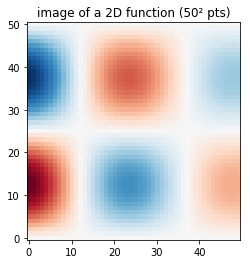

In [19]:
Ndata = 50
xgrid = np.linspace(0,1, Ndata)
ygrid = np.linspace(0,1, Ndata+1) # use a slighly different size to check differences
zgrid = np.linspace(0,1, Ndata+2)

f_2d_grid = f_2d(xgrid.reshape(-1,1), ygrid)

plt.imshow(f_2d_grid.T)
plt.title(u'image of a 2D function ({}² pts)'.format(Ndata));

f_2d_grid.shape

## 2) Use interpolators

The 3D case

In [10]:
f_3d_grid = f_3d(xgrid.reshape(-1,1,1), ygrid.reshape(1,-1,1), zgrid)
f_3d_grid.shape

(500, 501, 502)

Try several interpolation routines.

Notice how each routine has its special way (API) to
 
1. build the interpolator (instanciation)
2. call the interpolator (evaluation)

In [20]:
# Define the grid to interpolate on :
Ninterp = 10000
xinterp = np.linspace(0,1, Ninterp)
yinterp = np.linspace(0,1, Ninterp+1) # use a slighly different size to check differences
zinterp = np.linspace(0,1, 5) # small dimension to avoid size explosion
X2, Y2 = np.meshgrid(xinterp,yinterp)
xy_int = np.column_stack((X2.flatten(), Y2.flatten()))

### a) CloughTocher2DInterpolator

`CloughTocher2DInterpolator` uses an *unstructured data* which is provided as a list of points. Only for 2D.

`CloughTocher2DInterpolator(points, values)`
([documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CloughTocher2DInterpolator.html))

**Performance** (to points): 

* instanciation : 40 ms for 50x50 pts, 6.1 s for 500^2 pts
 
* evaluation : 553 ms for 50^2 pts in and 1 Mpts out, 700 ms for 500^2 pts in and 1 Mpts out, 54 s for 50^2 pts in and 100 Mpts out, 56 s for 500^2 pts in and 100 Mpts out.

In [91]:
# Build data for the interpolator
points_x, points_y = np.broadcast_arrays(xgrid.reshape(-1,1), ygrid)
points = np.vstack((points_x.flatten(),
                    points_y.flatten())).T
values = f_2d_grid.flatten()

In [86]:
# Build
%timeit f_2d_interp = CloughTocher2DInterpolator(points, values)

38.6 ms ± 586 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [92]:
f_2d_interp = CloughTocher2DInterpolator(points, values)

In [93]:
# Evaluate
%timeit f_2d_interp(xy_int)

56 s ± 130 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


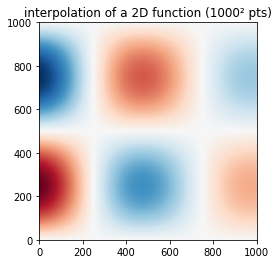

In [97]:
# Display
plt.imshow(f_2d_interp(xinterp.reshape(-1,1), yinterp).T)
plt.title(u'interpolation of a 2D function ({}² pts)'.format(Ninterp));

### b) RectBivariateSpline (scipy.interpolate)

*for 2D interpolation <span style='color:red;'>only</span> !*

`RectBivariateSpline(x, y, z, bbox=[None, None, None, None], kx=3, ky=3, s=0)`
([documentation](http://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RectBivariateSpline.html))

* x,y : 1-D arrays of coordinates in strictly ascending order.
* z :  2-D array of data with shape (x.size,y.size).

**Performance**

* instanciation : 0.2 ms for 50x50 pts, 20 ms for 500x500 pts.
* evaluation (to grid): 21 ms for 50^2 pts in and 1 Mpts out, 21 ms for 500^2 pts in and 1 Mpts out, 2.1 s for 50^2 or 500^2 pts in and 100 Mpts out.
* evaluation (to points): 170 ms for 50^2 pts in and 1 Mpts out, 500 ms for 500^2 pts in and 1 Mpts out, 17 s for 50^2 pts in and 100 Mpts out, 50 s for 500^2 pts in and 100 Mpts out.

In [69]:
%%timeit # Build
f_2d_interp = RectBivariateSpline(xgrid, ygrid, f_2d_grid)

20.3 ms ± 300 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [75]:
f_2d_interp = RectBivariateSpline(xgrid, ygrid, f_2d_grid)

In [76]:
%%timeit # Evaluate points output
f_2d_interp(X2, Y2, grid=False)

49.9 s ± 181 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
rbs1 = f_2d_interp(X2, Y2, grid=False)
rbs1

array([[-1.32910600e-18, -1.40294979e-18, -1.45469941e-18, ...,
         4.43521399e-19,  5.42937509e-19,  6.45497898e-19],
       [ 6.28339211e-03,  6.27699158e-03,  6.27034755e-03, ...,
         2.31598832e-03,  2.31380469e-03,  2.31153078e-03],
       [ 1.25664910e-02,  1.25536902e-02,  1.25404025e-02, ...,
         4.63186855e-03,  4.62750140e-03,  4.62295368e-03],
       ...,
       [-1.25664910e-02, -1.25536902e-02, -1.25404025e-02, ...,
        -4.63186855e-03, -4.62750140e-03, -4.62295368e-03],
       [-6.28339211e-03, -6.27699158e-03, -6.27034755e-03, ...,
        -2.31598832e-03, -2.31380469e-03, -2.31153078e-03],
       [-2.44929360e-16, -2.44679864e-16, -2.44420877e-16, ...,
        -9.02782329e-17, -9.01931143e-17, -9.01044760e-17]])

In [16]:
%%timeit # Evaluate grid output
f_2d_interp(xinterp, yinterp)

21.5 ms ± 191 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


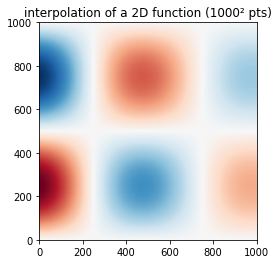

In [43]:
# Display
plt.imshow(f_2d_interp(X2, Y2, grid=False))
plt.title(u'interpolation of a 2D function ({}² pts)'.format(Ninterp));

### c) map_coordinates (scipy.ndimage)

notice that this method has no separation between _instanciation_ and _evaluation_ !

`map_coordinates(input, coordinates, output=None, order=3, mode='constant', cval=0.0, prefilter=True)`
([documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.map_coordinates.html))


**Performance** (to points): 

* 56 ms for 50^2 or 500^2 pts in and 1 Mpts out, 1.5 s for 50^2 pts in and 100 Mpts out, 5.8 s for 500^2 pts in and 100 Mpts out.
* 511 ms (5 Mpts in 3D)

In [100]:
# Prepare the coordinates to evaluate the array on :
points_x, points_y = np.broadcast_arrays(xinterp.reshape(-1,1), yinterp)
coord = np.vstack((points_x.flatten()*(len(xgrid)-1) , # a weird formula !
                   points_y.flatten()*(len(ygrid)-1)))
coord.shape

(2, 100010000)

In [73]:
%%timeit # Build and Evaluate
f_2d_interp = map_coordinates(f_2d_grid, coord, order=1)

57.5 ms ± 237 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [55]:
f_2d_interp = map_coordinates(f_2d_grid, coord, order=1)

In [56]:
# Reshape
f_2d_interp = f_2d_interp.reshape(len(xinterp), len(yinterp))

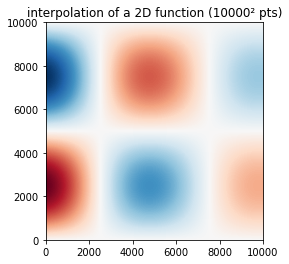

In [57]:
# Display 
plt.imshow(f_2d_interp.T)
plt.title(u'interpolation of a 2D function ({}² pts)'.format(Ninterp));

The 3D case

In [28]:
# Prepare the coordinates to evaluate the array on :
points_x, points_y, points_z = np.broadcast_arrays(xinterp.reshape(-1,1,1), yinterp.reshape(1,-1,1), zinterp)
coord = np.vstack((points_x.flatten()*(len(xgrid)-1), # a weird formula !
                   points_y.flatten()*(len(ygrid)-1),
                   points_z.flatten()*(len(zgrid)-1)
                   ))
coord.shape

(3, 5005000)

In [29]:
%%timeit # Build and Evaluate
f_3d_interp = map_coordinates(f_3d_grid, coord, order=1)
# Reshape
f_3d_interp = f_3d_interp.reshape(len(xinterp), len(yinterp), len(zinterp))

508 ms ± 6.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
f_3d_interp = map_coordinates(f_3d_grid, coord, order=1)
f_3d_interp = f_3d_interp.reshape(len(xinterp), len(yinterp), len(zinterp))
f_3d_interp.shape

(1000, 1001, 5)

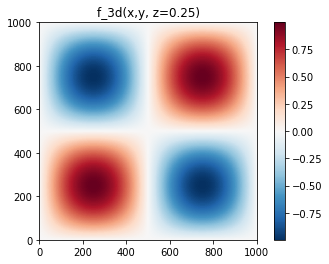

In [31]:
n_z = 1
plt.imshow(f_3d_interp[:,:,n_z])
plt.title('f_3d(x,y, z={:.2f})'.format(zinterp[n_z]))
plt.colorbar();

### e) RegularGridInterpolator (scipy.interpolate, starting v0.14)

[documentation](http://docs.scipy.org/doc/scipy-dev/reference/generated/scipy.interpolate.RegularGridInterpolator.html)

actual interpolation code: https://github.com/scipy/scipy/blob/master/scipy/interpolate/interpolate.py#L1577 (pure Python, no Cython involved!)

API:

`RegularGridInterpolator(points, values, [...])`
    
* `points`: tuple of ndarray of float, with shapes *(m1, ), ..., (mn, )*.  
  → The points defining the regular grid in n dimensions.
* `value`: array_like, shape *(m1, ..., mn, ...)*.  
  → The data on the regular grid in n dimensions.


**Performance**

* instanciation : 0.022 ms for 50^2 points, 0.025 ms for 500^2 pts
* evaluation (to points): 265 ms for 50^2 pts in and 1 Mpts out,
* in 1.8 s in 3D (5 Mpts)

In [12]:
%%timeit # Instanciate the interpolator
f_2d_interp = RegularGridInterpolator((xgrid, ygrid), f_2d_grid)

24.8 µs ± 239 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [13]:
f_2d_interp = RegularGridInterpolator((xgrid, ygrid), f_2d_grid)

In [21]:
# Prepare the coordinates to evaluate the array on :
points_x, points_y = np.broadcast_arrays(xinterp.reshape(-1,1), yinterp)
coord = np.vstack((points_x.flatten(),
                   points_y.flatten()))
coord.shape

(2, 100010000)

In [ ]:
%%timeit # Interpolate grid
f_2d_interp_res = f_2d_interp(coord.T)

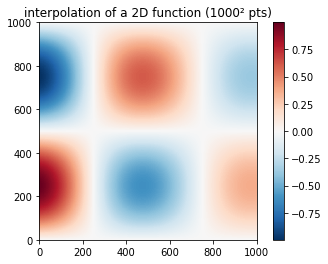

In [37]:
# Display 

f_2d_interp_res = f_2d_interp(coord.T).reshape(len(xinterp), len(yinterp))

plt.imshow(f_2d_interp_res.T)
plt.title(u'interpolation of a 2D function ({}² pts)'.format(Ninterp));
plt.colorbar();

#### The 3D case

In [38]:
f_3d_interp = RegularGridInterpolator((xgrid, ygrid, zgrid), f_3d_grid)

In [39]:
# Prepare the coordinates to evaluate the array on :
points_x, points_y, points_z = np.broadcast_arrays(xinterp.reshape(-1,1,1), yinterp.reshape(1,-1,1), zinterp)
coord = np.vstack((points_x.flatten(), # a weird formula !
                   points_y.flatten(),
                   points_z.flatten()
                   ))
coord.shape

(3, 5005000)

In [40]:
%%timeit # Interpolate
f_3d_interp_res = f_3d_interp(coord.T).reshape(len(xinterp), len(yinterp), len(zinterp))

2.88 s ± 30.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


table

Method  | Instanciation | Evaluation (1Mpts 2D) | (5 Mpts, 3D)
------  | ------------- | --------------------    ---
dolo    | 0.010 ms   | 13 ms | 105 ms
RegularGridInterpolator | 0.022 ms | 116 ms | 1.8 s



Conclusion: Dolo's Multilinear interpolation (for an *even grid* only) is still the best!

In [3]:
50*50

2500